In [1]:
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

path = 'https://github.com/oregon-data-science/DSCI101/raw/main/data/'

"imports complete" 

'imports complete'

## Data import and clean-up

We will be looking at the penguins dataset. `datascience` doesn't have a direct method of removing NaN values, but we can get creative with the `.where()` function.

In [2]:
penguins = Table().read_table(path + "penguins.csv")
penguins = penguins.where("body_mass_g", are.above(0)).where("sex", are.containing("male")) ### removes nan values

Let's look at the average body weights of the different species:

In [3]:
penguins.select("species", "body_mass_g").group("species", np.average)

species,body_mass_g average
Adelie,3706.16
Chinstrap,3733.09
Gentoo,5092.44


Gentoo seems to be the biggest, and Adelie might be the smallest (but not by much). Let's focus on the difference between Gentoo penguins and Chinstrap penguins for the first round of AB testing. We will filter Adelie species out of the table, then use the grouping function to pull out the mean body mass of the Gentoo and Chinstrap penguins.

In [4]:
gentoo_chinstrap = penguins.where("species", are.not_equal_to("Adelie"))
gentoo_chinstrap.select("species", "body_mass_g").group("species", np.average)

species,body_mass_g average
Chinstrap,3733.09
Gentoo,5092.44


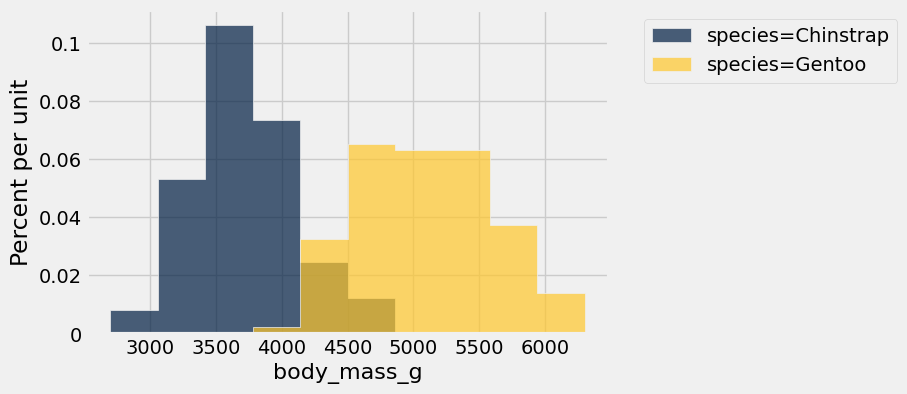

In [5]:
gentoo_chinstrap.hist("body_mass_g", group = "species");

## Test statistic

A reasonable test statistic for AB testing is the difference in mean body mass between penguin species. We will substract the mean mass of Chinstrap penguins from the mean mass of Gentoo penguins.

In [6]:
means = gentoo_chinstrap.select("species", "body_mass_g").group("species", np.average).column(1)
means.item(1) - means.item(0)

1359.3487394957988

Before we get on with the simulations, let take a look at this observed statistic. What does this value tell you? That Gentoo penguins are bigger than Chinstrap penguins?

Let this intuition guide you when you are formulating your null and alternative hypotheses.

## Hypotheses

A reasonable null hypothesis might state there is no difference between the body masses of the two species of penguins, or:

$H_0: \mu_G - \mu_C = 0$

where $\mu_G$ and $\mu_C$ are the mean body masses of the Gentoo and Chinstrap penguins, respectively. In other words, if we substract the mean body masses from each other, we should get a number close to 0.

A reasonable alternative hypothesis might state that there is a difference between the body masses of the two species of penguins, or:

$H_A: \mu_G - \mu_C \neq 0$

This alternative hypothesis states that the difference between means is not equal to 0, but it doesn't address any directionality (ie. are Gentoos bigger or are Chinstraps bigger?).

We can be more specific with our alternative hypotheses:

$H_1: \mu_G - \mu_C > 0$, which is the same as saying $H_1: \mu_G > \mu_C$, that Gentoos are bigger.

$H_2: \mu_G - \mu_C < 0$, which is the same as saying $H_2: \mu_G < \mu_C$, that Gentoos are smaller.

What values of $\mu_G - \mu_C$ support $H_1$? What values support $H_2$?

Big positive values will support $H_1$, while big negative values will support $H_2$.


## AB testing

The null hypothesis with AB testing is that there is no difference in means between group A and group B. If this was true, then shuffling the group labels should not change the relationship between group label (species) and the numerical variable (body mass). In other wordls, it doesn't matter if a penguin is a Gentoo or a Chinstrap; their body mass is drawn from the same overall distribution regardless.

We can see how shuffling the group labels affects the body mass distribution.

Observed statistic:1359.3487394957988
Shuffled statistic:-23.16176470588198


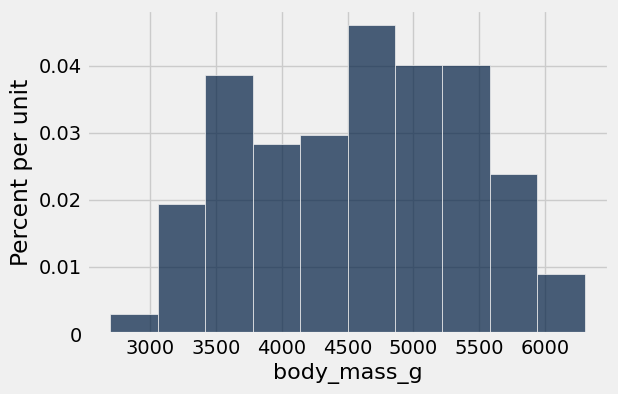

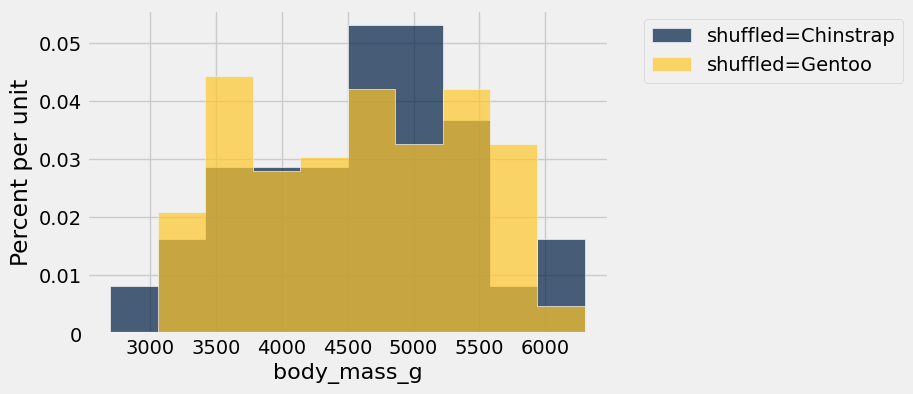

In [7]:
### overall distribution

gentoo_chinstrap.hist("body_mass_g")

## if we shuffled "species" labels
gentoo_chinstrap = gentoo_chinstrap.with_column("shuffled", 
                                                gentoo_chinstrap.sample(with_replacement=False).column("species"))

gentoo_chinstrap.hist("body_mass_g", group = "shuffled");

shuffled_means = gentoo_chinstrap.select("shuffled", "body_mass_g").group("shuffled", np.average).column(1)
shuffled_means.item(1) - shuffled_means.item(0)

obs_stat = means.item(1) - means.item(0)
print("Observed statistic:" + str(obs_stat))
print("Shuffled statistic:" + str(shuffled_means.item(1) - shuffled_means.item(0)))

If the null hypothesis is true, we might expect to see a histogram like the one above, where the distributions of body mass of Chinstrap penguins and Gentoo penguins are almost completely overlapping. This is the view that the null hypothesis presents. We can simulate this view may times to understand how probable this view is given the observed test statistic we calculated above.

On to the test! Let's make some functions to carry out the AB testing.

We need to do the following:
- Calculate the difference of means between group A and group B (observed statistic)
- Shuffle the group A and group B labels
- Calculate the difference of means between the shuffled group A and group B (simulated statistic)
- Store this simulated statistic and repeat at least 1000 times

In [8]:
## Let's make a function to claculate the difference of means:

def difference_of_means(table, num_label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups"""
    
    #table with the two relevant columns
    reduced = table.select(num_label, group_label)  
    
    # table containing group means
    means_table = reduced.group(group_label, np.average)
    # array of group means
    means = means_table.column(1)
    
    return means.item(1) - means.item(0)

help(difference_of_means)

Help on function difference_of_means in module __main__:

difference_of_means(table, num_label, group_label)
    Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups



In [9]:
## package everything into a function

def one_simulated_difference(table, num_label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = table.sample(with_replacement = False
                                                    ).column(group_label)
    
    # table of numerical variable and shuffled labels
    shuffled_table = table.select(num_label).with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, num_label, 'Shuffled Label')   

In [10]:
## what do we do when we want to simulate somethign over and over way?? For loop! 
num_simulations = 1000
differences = make_array()

for i in np.arange(num_simulations):
    new_difference = one_simulated_difference(gentoo_chinstrap, 'body_mass_g', 'species')
    differences = np.append(differences, new_difference)

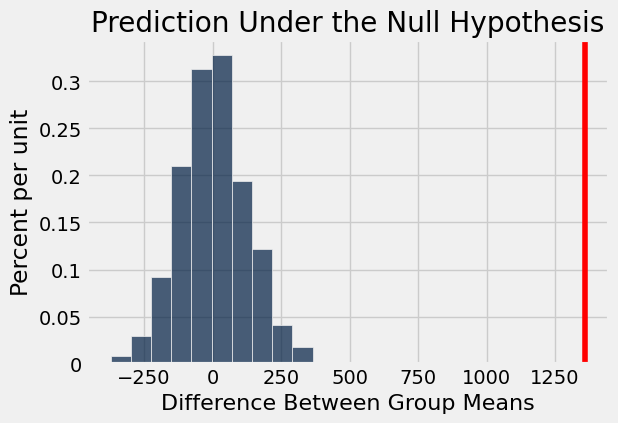

In [11]:
Table().with_column('Difference Between Group Means', differences).hist()
plots.axvline(x = obs_stat, color = "red")
plots.title('Prediction Under the Null Hypothesis');

Let's calculate a p-value. Recall, we can think about the p-value in various ways:
- the p-value is the probability that the null hypothesis is true given our observed test statistic.
- the p-value is the probability of observing test statistics equal to or more extreme than the observed test statistic.

Large p-values lend more support to the null hypothesis, whereas small p-values support the alternative hypothesis. Making sure we calculate the correct p-value with respect to the alternative hypothesis is important in determining whther or not we can accept or reject the null hypothesis.

Recall the null $H_0$ and the alternative hypotheses ($H_1$ and $H_2$) we made above:

$H_0: \mu_G - \mu_C = 0$, there is no difference in mean body mass between species.

$H_1: \mu_G - \mu_C > 0$, which is the same as saying $H_1: \mu_G > \mu_C$, that Gentoos are bigger.

$H_2: \mu_G - \mu_C < 0$, which is the same as saying $H_2: \mu_G < \mu_C$, that Gentoos are smaller.

Our observed statistic is much greater than 0, suggesting that Gentoo's are the bigger species. Let's see how many of our simulated test statisitics are as big or bigger than this observed test statistic. If there are many simulated test statistics that are as extreme as our observed test statistic, this provides evidence for the null hypothesis.

In [12]:
sum(differences >= obs_stat)/1000

0.0

This p-value is well below the cut-off of 0.05, which means we can reject our null hypothesis. The small p-value also shows support for the alternative hypothesis $H_1$, that states Gentoos are the bigger species.

For fun, we can switch the comparitor symbol to see if we have any support for $H_2$, that Gentoo's are smaller.

In [13]:
sum(differences <= obs_stat)/1000 ## differences less than or equal to obs_stat support H_2.

1.0

This large p-value shows we don't have support for the hypothesis that Gentoos are the smaller species. While we didn't need to calculte the p-value for $H_2$, since this p-value is equals $1-p_1$, where $p_1$ is the p-value calculated for $H_1$, it demonstrates that you should take care in how you are calculating the p-value, so you don't accidently accept the null hypothesis. Ask yourself what values of your simulated test statisics support each alternative hypothesis. You can also revisit the distribution of your test statistic and compare those values to your observed statistic.

To illustrate which direction to look for extreme values, suppose our observed statistic was 250. If we think Gentoos are still bigger (suggested by an observed stat > 0), we are going to focus on values that are larger than or equal to 250. These values offer support for this alternative hypothesis. Values smaller than 250 do not. The highlighted region on the histogram below represents the p-value (~0.02). Since this p-value is less than 0.05, we can reject the null infavor of the alternative hypothesis that Gentoos are the bigger species.

p-value = 0.027


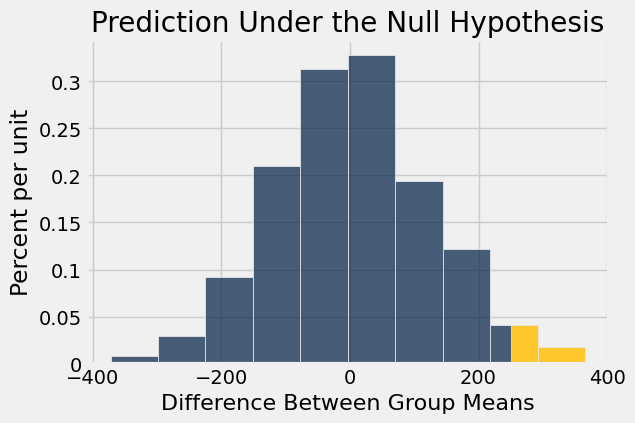

In [14]:
Table().with_column('Difference Between Group Means', differences).hist(left_end=250)
plots.title('Prediction Under the Null Hypothesis');

print("p-value = " + str(round(sum(differences>=250)/1000, 3)))


If our observed statistic was -250, we might think Gentoos are the **smaller** species. We can then focus on values **less than or equal to** -250. These values offer support for this alternative hypothesis. We calculate the p-value and find that it's ~0.02, also below the cut-off of 0.05. If this observed statistic was real, we could reject the null hypothesis in favor of an alternative that states that Gentoos are the smaller species.

p-value = 0.016


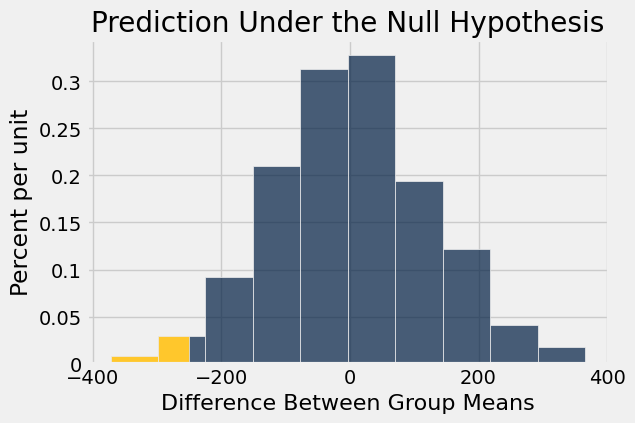

In [15]:
Table().with_column('Difference Between Group Means', differences).hist(right_end=-250)
plots.title('Prediction Under the Null Hypothesis');

print("p-value = " + str(round(sum(differences<=-250)/1000, 3)))

## Conclusions and next steps

Using AB testing, we found that Gentoo penguins are signficantly larger than Chinstrap penguins in terms of body mass (difference = 1359.35 g; p-value < 1/1000).

Are Chinstrap penguins significantly larger than Adelie penguins? Using the methods we used above, see if you can answer this question using AB testing.